# Homoscedasticity

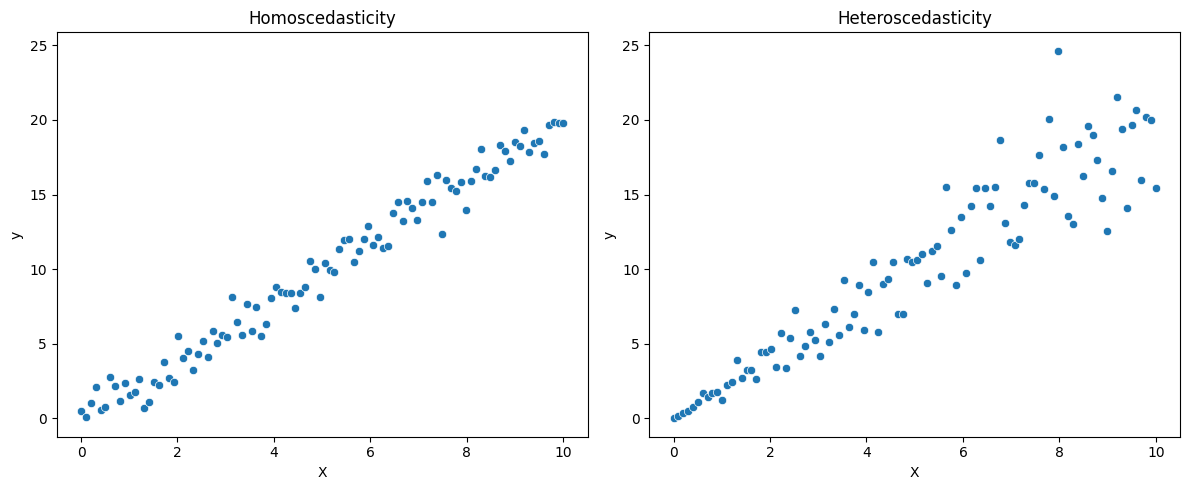

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(42)

# Generate X values
X = np.linspace(0, 10, 100)

# 1. Homoscedastic data (constant noise)
noise_homo = np.random.normal(0, 1, size=X.shape)
y_homo = 2 * X + noise_homo

# 2. Heteroscedastic data (noise increases with X)
noise_hetero = np.random.normal(0, 0.4 * X, size=X.shape)  # noise proportional to X
y_hetero = 2 * X + noise_hetero

# Put into DataFrames
df_homo = pd.DataFrame({'X': X, 'y': y_homo})
df_hetero = pd.DataFrame({'X': X, 'y': y_hetero})

# Plotting, side by side
plt.figure(figsize=(12, 5))

# Subplot with regular data
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x='X', y='y', data=df_homo)
plt.title('Homoscedasticity')

# Subplot with outliers
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x='X', y='y', data=df_hetero)
plt.title('Heteroscedasticity')

# Visualization trick: adapt the vertical limits (y lim) of the first plot,
# so that it is the same as the second plot (which has more spread)
ax1.set_ylim(ax2.get_ylim())

# Showing the final result
plt.tight_layout()
plt.show()

To test for homoscedasticity we'll use the [Breush-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test), which returns a p-value:

* Null hypothesis (H0): Residuals have constant variance (good — homoscedasticity)
* Alternative (H1): Residuals' variance depends on X (bad — heteroscedasticity)

If the test gives a small p-value (e.g., < 0.05), you reject H0 → there is heteroscedasticity.

In [29]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

# Add intercept term to X, required for OLS regression from statsmodels
X_with_const = sm.add_constant(X)

# Build the models: on for each set
model_homo   = sm.OLS(y_homo,   X_with_const).fit()
model_hetero = sm.OLS(y_hetero, X_with_const).fit()

# Breusch-Pagan test
# (residuals, design matrix)
bp_test_homo   = sms.het_breuschpagan(model_homo.resid, model_homo.model.exog)
bp_test_hetero = sms.het_breuschpagan(model_hetero.resid, model_hetero.model.exog)

# Output
print('p-value (heteroscedastic data) : ' + str(bp_test_homo[1]))
print('p-value (homoscedastic data)   : ' + str(bp_test_hetero[1]))

p-value (heteroscedastic data) : 0.6013945776291476
p-value (homoscedastic data)   : 0.0002994118347711689


# Multicollinearity

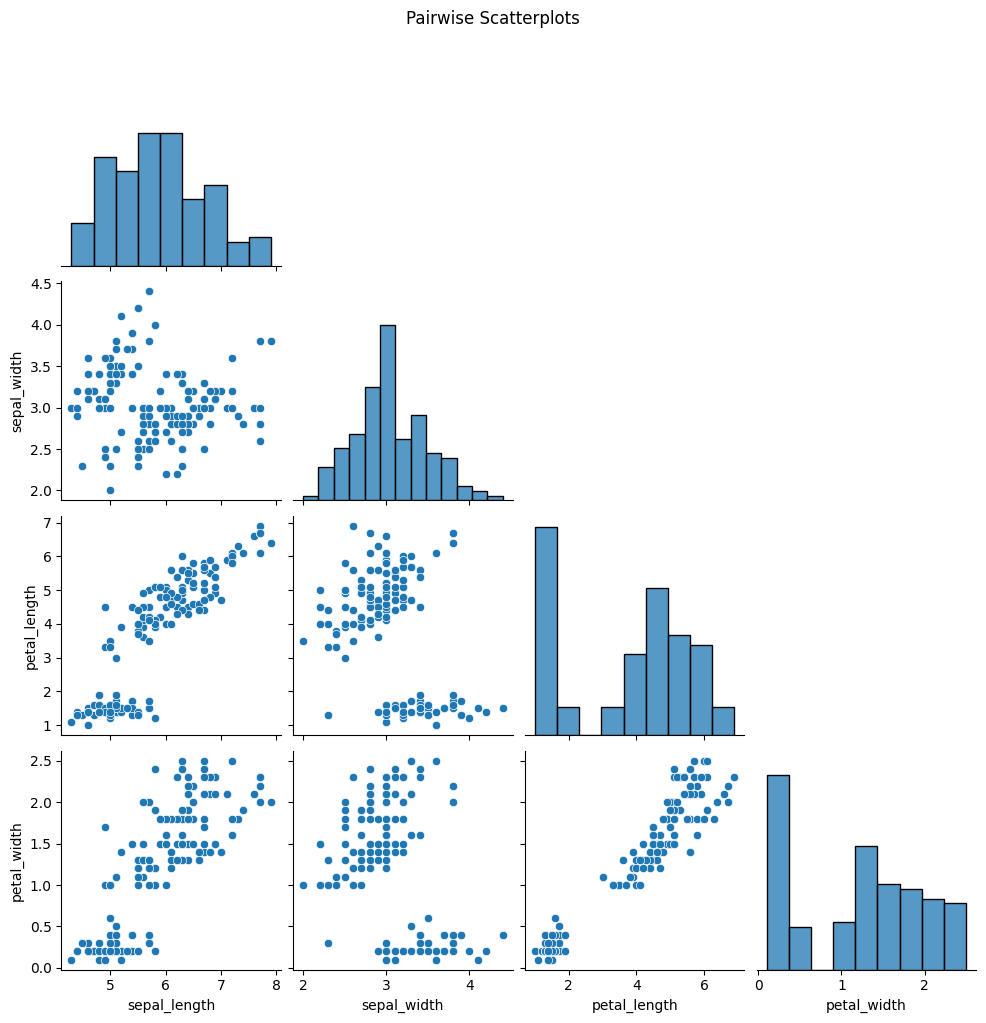

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Load iris data from the seaborn package
df = sns.load_dataset('iris')

# Select only the numerical columns (basically removing the "species" column)
numeric_df = df.select_dtypes(include='number')

# Create the pairplot with Seaborn
sns.pairplot(numeric_df, corner=True)  # corner=True avoids redundant plots
plt.suptitle("Pairwise Scatterplots", y=1.02)
plt.show()

In [ ]:
# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the matrix (main diag is expected to be one, the matrix
# should be symmetrical)
print(correlation_matrix)

              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.117570      0.871754     0.817941
sepal_width      -0.117570     1.000000     -0.428440    -0.366126
petal_length      0.871754    -0.428440      1.000000     0.962865
petal_width       0.817941    -0.366126      0.962865     1.000000


In [ ]:
# Compute Variance Inflation Factor (VIF)
#
#            1
# VIFi = -----------
#         1 - Ri^2
#
# Where Ri^2 is the coefficient of determination from regressing the i-th variable
# on all the other predictors.

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# statsmodels library expects also a constant column (the intercept) for its functions
numeric_df['intercept'] = 1

# Computing VIF, storing it in a list
vif = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

# Building a named dataframe, for better display
vif = pd.DataFrame({
    'variable' : numeric_df.columns,
    'vif' : vif
})

# Taking a look
print(vif)

       variable         vif
0  sepal_length    7.072722
1   sepal_width    2.100872
2  petal_length   31.261498
3   petal_width   16.090175
4     intercept  131.113086


# Outliers, univariate

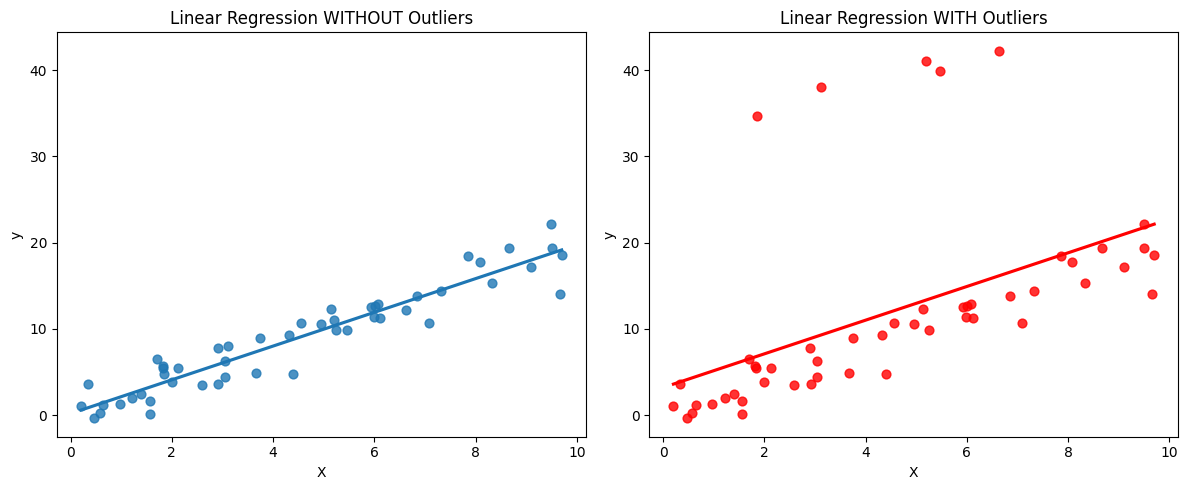

In [7]:
# A synthetic dataset, into which we inject an outlier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set random seed for reproducibility
np.random.seed(42)

# Create artificial dataset: y = 2x + noise
X = np.random.uniform(0, 10, 50)       #mim, max, number of samples
y = 2 * X + np.random.normal(0, 2, 50) #mean, st dev, number of samples

# Put it into a DataFrame
df = pd.DataFrame({'X': X, 'y': y})

# A copy that will contain the outliers: big jumps to the last 5 points
df_outliers = df.copy()
df_outliers.loc[45:49, 'y'] += 30  # Add big jumps to last 5 points

# Plotting the two regressions side by side using the seaborn
# built-in regression plot
plt.figure(figsize=(12, 5))

# Subplot with regular data
ax1 = plt.subplot(1, 2, 1)
sns.regplot(x='X', y='y', data=df, ci=None, scatter_kws={'s': 40})
plt.title('Linear Regression WITHOUT Outliers')

# Subplot with outliers
ax2 = plt.subplot(1, 2, 2)
sns.regplot(x='X', y='y', data=df_outliers, ci=None, scatter_kws={'s': 40}, color='r')
plt.title('Linear Regression WITH Outliers')

# Visualization trick: adapt the vertical limits (y lim) of the first plot,
# without the outliers, so that it is the same as the second plot (with the
# outliers) to help visualize the differences in the regression lines
ax1.set_ylim(ax2.get_ylim())

# Shoring the final result
plt.tight_layout()
plt.show()

In [12]:
# Z score test for normally distributed data

from scipy.stats import zscore
import numpy as np

# computing z score
z_scores = np.abs(zscore(df_outliers['y']))

# first threshold: excluding samples that are 2-sigma from the mean
outliers = np.where(z_scores > 2)
print("Outliers at sigma>2 (95%)  :", outliers)

# second threshold: excluding samples that are 3-sigma from the mean
outliers = np.where(z_scores > 3)
print("Outliers at sigma>3 (99.7%):", outliers)

Outliers at sigma>2 (95%)  : (array([45, 46, 47, 48, 49]),)
Outliers at sigma>3 (99.7%): (array([], dtype=int64),)


Not all outliers are excluded at 3 sigma! Remember that:

* in our synthetic dataset, we injected 5 outliers over 30 samples in total. Not
  so rare of an event! One may wonder if they are actually outliers or if the
  distribution is bimodal
* outliers contribute to the general statistics! Our outliers samples would stick out (have a very high Z) if it were computed on the "clean" dataset (without the outliers). But they, too, contribute to the general mean

# Outliers, multivariate

A simple test is the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance), which measures how far a point is from the center of a multivariate distribution, taking into account the correlations between variables. For the actual formula we use the [function from the scipy.spatial package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html)

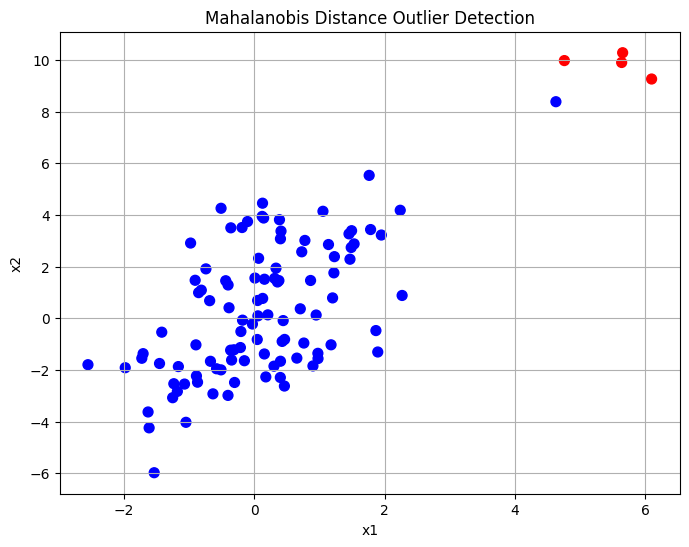

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Create sample data: two variables (x1 and x2) in an elliptical shape
np.random.seed(0)
x1 = np.random.normal(0, 1, 100) #mean, st dev, number of samples
x2 = x1 + 2 * np.random.normal(0, 1, 100)

# Add a few outliers
x1 = np.concatenate([x1, np.random.normal(5, 1, 5)])
x2 = np.concatenate([x2, np.random.normal(10, 1, 5)])

# Put into DataFrame
df = pd.DataFrame({'x1': x1, 'x2': x2})

# Compute Mahalanobis Distance. Apart from the two variables, the function
# requires the inverse of the covariance matrix and the center (mean) of the
# data. We want to measure how far is each data point from the data center,
# taking into account the shape (covariance) of the data
cov_matrix = np.cov(df['x1'], df['x2'], rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_vals = df[['x1', 'x2']].mean().values
mahalanobis_dist = df.apply(lambda row: distance.mahalanobis(row, mean_vals, inv_cov_matrix), axis=1)

# Threshold for outliers (Chi-square 99% quantile, 2 degrees of freedom).
# Remember that when your data is multivariate normal, the squared Mahalanobis
# distance (not the distance itself) follows a Chi-square distribution with
# degrees of freedom=number of variablesdegrees of freedom=number of variables.
# For reference: https://www.chisquaretable.net/
threshold = np.sqrt(9.21)

# Identify outliers
df['outlier'] = mahalanobis_dist > threshold

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(df['x1'], df['x2'], c=df['outlier'].map({False: 'blue', True: 'red'}), s=50)
plt.title('Mahalanobis Distance Outlier Detection')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()